* Add wind speed, 

* M-O approaches to latent heat flux, 
* Find downvalley and up valley potential temps (Schofield pass SNOTEL) and note elevation of each

* SCHOFIELD PASS SNOTEL STATION: 737

In [2]:
import os
import act
import glob
import xarray as xr

import sys
sys.path.append('/home/elilouis/sublimationofsnow')
import sosutils
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import altair as alt
import ftplib
import pytz
import datetime
import metpy
from metpy.units import units
import pint_xarray
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# User Inputs

## SOS

In [3]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# datelist = ['20221031', '20221101', '20221102']
datelist = ['20221215', '20221216', '20221217', '20221218', '20221219']
start_date = datelist[0]
end_date = datelist[-1]

### Define variable list to extract

In [4]:
VARIABLE_NAMES = [  
    'spd_1m_c',     'dir_1m_c',     'u_1m_c',   'v_1m_c',   'w_1m_c',   'u_w__1m_c',    'v_w__1m_c',  'u_tc__1m_c',  'v_tc__1m_c',   'u_h2o__1m_c',  'v_h2o__1m_c',   'w_tc__1m_c',   'w_h2o__1m_c',
    'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
    'tc_1m_c', 'tc_2m_c', 'tc_3m_c', 'tc_5m_c', 'tc_10m_c', 'tc_15m_c', 'tc_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c',
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c',
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c'
]

## ECOR

In [5]:
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
met_kp = 'gucmetS3.b1'

# start_date = '2022-10-31'
# end_date = '2022-11-02'
start_date = '20221215'
end_date = '20221219'

output_dir = '/data2/elilouis/sublimationofsnow/'
ecor_gothic_path = os.path.join(output_dir, ecor_gothic)
ecor_kp_path = os.path.join(output_dir, ecor_kp)
met_gothic_path = os.path.join(output_dir, met_gothic)
met_kp_path = os.path.join(output_dir, met_kp)

In [6]:
ecor_gothic_path,ecor_kp_path,met_gothic_path,met_kp_path

('/data2/elilouis/sublimationofsnow/guc30ecorM1.b1',
 '/data2/elilouis/sublimationofsnow/guc30ecorS3.b1',
 '/data2/elilouis/sublimationofsnow/gucmetM1.b1',
 '/data2/elilouis/sublimationofsnow/gucmetS3.b1')

In [7]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Data Download

## SOS

In [8]:
example_dataset = xr.open_dataset(sosutils.download_sos_data_day(datelist[0], sos_download_dir))

In [9]:
datasets = [xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir))[VARIABLE_NAMES] for date in datelist]

sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')
sos_df = sos_ds.to_dataframe().reset_index()

## ECOR

In [10]:
from tempfile import TemporaryDirectory
with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_gothic,    start_date,    end_date,
        output = temp_dir
    )
    ecor_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_kp,    start_date,    end_date,
        output = temp_dir
    )
    ecor_kps_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    met_gothic,    start_date,    end_date,
        output = temp_dir
    )
    met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

[DOWNLOADING] guc30ecorM1.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221219.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221219.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221215.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221216.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221217.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221218.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221219.000000.cdf


# Calculations

## Potential temperatures

In [11]:
met_gothic_ds['potential temperature'] \
                        = metpy.calc.potential_temperature(met_gothic_ds['atmos_pressure'] * units.kPa, met_gothic_ds['temp_mean'] * units.celsius).pint.to(units.celsius)

for i in range(1,21):
    height_adj_pressure = metpy.calc.add_height_to_pressure(
        sos_ds['P_10m_c'] * units.millibar, 
        i*units.m - (10*units.m)
    )
    sos_ds[f'Tpot_{i}m_c'] = metpy.calc.potential_temperature(    
        height_adj_pressure,
        sos_ds[f'T_{i}m_c'] * units.celsius
    ).pint.to(units.celsius)


## Sublimation/evaporation

In [12]:
ecor_kps_ds['sublimation rate (mm/hr)'] = 3600*ecor_kps_ds['lv_e']/2.838e6
ecor_gothic_ds['sublimation rate (mm/hr)'] = 3600*ecor_gothic_ds['lv_e']/2.838e6
sos_ds['sublimation rate (mm/hr)'] = 3600*sos_ds['w_h2o__3m_c']/1e3
sos_ds['lv_e'] = (sos_ds['w_h2o__3m_c']/1e3)*2.838e6

# Plot

## Get nighttime df

In [13]:
import matplotlib.dates as mdates
import numpy as np
from matplotlib import dates

night_df = sosutils.get_nightime_df(
    'US/Mountain', 
    ecor_gothic_ds['lat'].values[0], 
    ecor_gothic_ds['lon'].values[0],
    [datetime.datetime.strptime(date_str, '%Y%m%d') for date_str in ecor_gothic_ds.attrs['_file_dates']]
)

## Wind dir, pot. temps, and moisture fluxes at Gothic ad KPS sites

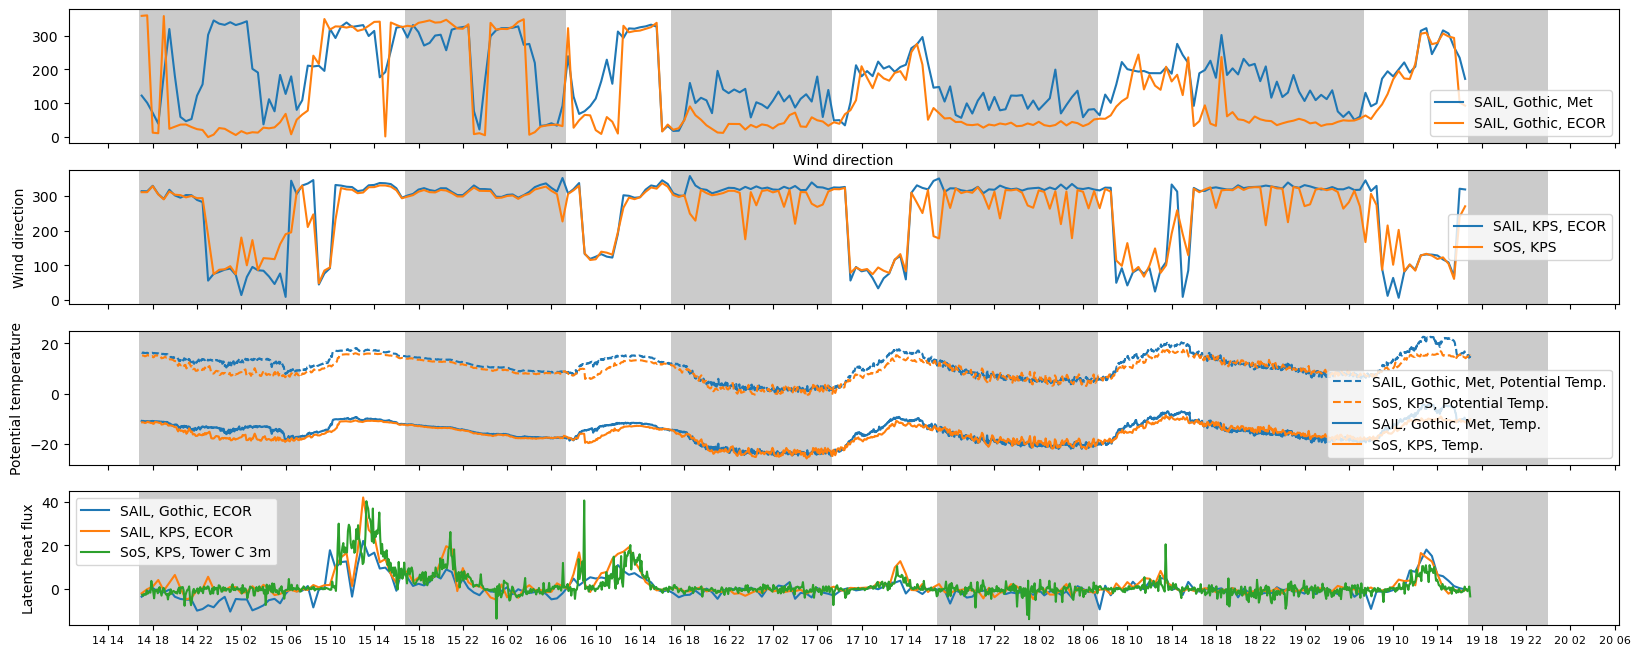

In [14]:
fig, axes = plt.subplots(4,1, figsize=(20,8), sharex=True)

met_gothic_ds_30min = met_gothic_ds.resample(time='30Min').mean()
sos_ds_30min = sos_ds.resample(time='30Min').mean()

# get local_time zones
met_gothic_ds_30min = sosutils.modify_xarray_timezone(met_gothic_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = sosutils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_gothic_ds = sosutils.modify_xarray_timezone(ecor_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_kps_ds = sosutils.modify_xarray_timezone(ecor_kps_ds, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds_30min = sosutils.modify_xarray_timezone(sos_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds = sosutils.modify_xarray_timezone(sos_ds, pytz.UTC, pytz.timezone('US/Mountain'))


# plot
axes[0].plot(met_gothic_ds_30min.local_time, met_gothic_ds_30min['wdir_vec_mean'], label='SAIL, Gothic, Met')
axes[0].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['wind_dir'], label='SAIL, Gothic, ECOR')
axes[0].set_xlabel('Wind direction')

axes[1].plot(ecor_kps_ds.local_time, ecor_kps_ds['wind_dir'], label='SAIL, KPS, ECOR')
axes[1].plot(sos_ds_30min.local_time, sos_ds_30min['dir_3m_c'], label='SOS, KPS')
axes[1].set_ylabel('Wind direction')

axes[2].plot(met_gothic_ds.local_time, met_gothic_ds['potential temperature'], label='SAIL, Gothic, Met, Potential Temp.', linestyle='--', color='tab:blue')
axes[2].plot(sos_ds.local_time, sos_ds['Tpot_3m_c'], label='SoS, KPS, Potential Temp.', linestyle='--', color='tab:orange')
axes[2].plot(met_gothic_ds.local_time, met_gothic_ds['temp_mean'], label='SAIL, Gothic, Met, Temp.', color='tab:blue')
axes[2].plot(sos_ds.local_time, sos_ds['T_3m_c'], label='SoS, KPS, Temp.', color='tab:orange')
axes[2].set_ylabel('Potential temperature')

# axes[3].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['sublimation rate (mm/hr)'], label='SAIL, Gothic, ECOR')
# axes[3].plot(ecor_kps_ds.local_time, ecor_kps_ds['sublimation rate (mm/hr)'], label='SAIL, KPS, ECOR')
# axes[3].plot(sos_ds.local_time, sos_ds['sublimation rate (mm/hr)'], label='SoS, KPS, Tower C 3m')

axes[3].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['lv_e'], label='SAIL, Gothic, ECOR')
axes[3].plot(ecor_kps_ds.local_time, ecor_kps_ds['lv_e'], label='SAIL, KPS, ECOR')
axes[3].plot(sos_ds.local_time, sos_ds['lv_e'], label='SoS, KPS, Tower C 3m')
axes[3].set_ylabel('Latent heat flux')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))   #to get a tick every 4 hrs
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax.xaxis.set_tick_params(labelsize=8)
    ax.legend()
    for i,row in night_df.iterrows():
        ax.axvspan(row['sunset'], row['sunrise'], facecolor='0.2', alpha=0.25)

## Potential temperature and wind profiles

In [75]:
# sos_tidy_temps = sos_ds[[f for f in sos_ds.data_vars if f.startswith('T_') or f.startswith('Tpot_')]]
sos_tidy_temps = sos_ds[[f for f in sos_ds.data_vars if f.startswith('T_') or f.startswith('Tpot_') or f.startswith('spd_', ) or f.startswith('w_h2o__') or f.startswith('u_h2o__') or f.startswith('v_h2o__')]]

sos_tidy_temps = sos_tidy_temps.resample(time='360Min').mean().to_dataframe().reset_index()
# Change the timezone ( the xarray dimensions were still in UTC)
sos_tidy_temps = sosutils.modify_df_timezone(sos_tidy_temps, 'UTC', 'US/Mountain')

sos_tidy_temps = sos_tidy_temps.melt(id_vars='time')
sos_tidy_temps['height'] = sos_tidy_temps['variable'].apply(sosutils.height_from_variable_name)
sos_tidy_temps['tower'] = sos_tidy_temps['variable'].apply(sosutils.tower_from_variable_name)
sos_tidy_temps['measurement'] = sos_tidy_temps['variable'].apply(sosutils.measurement_from_variable_name)


In [76]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [77]:
sos_tidy_temps.measurement.unique()

array(['wind speed', 'u_h2o_', 'v_h2o_', 'w_h2o_', 'temperature',
       'potential temperature'], dtype=object)

In [84]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'wind speed'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Wind Speed (m/s)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

alt.Chart(...)

In [82]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'potential temperature'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Potential Temperature (˚C)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [85]:
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'u_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'u_h2o_']['value']*1000
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'v_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'v_h2o_']['value']*1000
sos_tidy_temps.loc[sos_tidy_temps.measurement == 'w_h2o_', 'value'] = sos_tidy_temps.loc[sos_tidy_temps.measurement == 'w_h2o_']['value']*1000



In [154]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'w_h2o_'
).mark_line().encode(
    alt.X('value:Q', sort='-y', title=None),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'), title='Vertical moisture flux (m/s * g/kg)')
).properties(
    width=50, 
    height=100
).resolve_scale(
    x='independent'
).configure_header(
    titleOrient='bottom'
)

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

# Rotate coordinate system for limited time period

In [95]:
# sliced_sos_ds = sos_ds.sel(time=slice('2022-12-16 22:00', '2022-12-17 00:00'))
# sliced_sos_ds = sos_ds.sel(time=slice('2022-12-18 00:00', '2022-12-18 02:00'))
# sliced_sos_ds = sos_ds.sel(time=slice('2022-12-17 19:00', '2022-12-17 21:00'))
tidy_df = sosutils.get_tidy_dataset(sos_ds, VARIABLE_NAMES)
# Change the timezone ( the xarray dimensions were still in UTC)
tidy_df = sosutils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

tidy_df = tidy_df[
    (tidy_df.time > datetime.datetime(2022, 12, 18, 0)) &
    (tidy_df.time < datetime.datetime(2022, 12, 18, 2))
]

In [96]:
tidy_streamwise_df = sosutils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)

### Look at changes to vector variables

In [97]:

alt.Chart(
    pd.concat([
        tidy_df.assign(coordinates='Sonic'),
        tidy_streamwise_df.assign(coordinates='Streamwise')
    ])
).transform_filter(
    alt.FieldOneOfPredicate('height', [1,2,3,5,10,15,20]) # limite to measurements at sonic heights
).transform_filter(
    alt.FieldOneOfPredicate('measurement', [
        'u','v','u_w_','v_w_','u_tc_','v_tc_','u_h2o_','v_h2o_',
    ]) # limit to measurements at sonic heights
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('coordinates:N')
).properties(
    width=150,
    height=50
).facet(
    column = 'height:O',
    row = 'measurement'
).resolve_scale(y='independent')

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

# Calculate nondimensional numbers

## **Obhukov Length**

$$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$$

$u_*$ = local scale/shear velocity

$\overline{\theta_v} $ = virtual potential temperature (mean over reynolds-averaging period)

$ \overline{w'\theta'_v} $ = vertical turbulent flux of sensible heat (in terms of virtual potential temperature, mean over reynolds-averaging period)

$k$ = von kármán constant

$$ u_* = \sqrt{\frac{\overline{u'w'}}{\rho}} $$


$\overline{u'w'}$ = vertical turbulent flux of momentum (mean over reynolds-averaging period)

$\rho$ = air density

To calculate the shear velocity we need to rotate the coordinate system to point upstream.

In [98]:
import metpy.constants
import metpy.calc
from metpy.units import units
import pint

In [172]:
TOWER = 'c'
HEIGHT = 3

PRESSURE_TOWER = 'c'
PRESSURE_HEIGHT = 10

# Note that I need to use xarray datasets here for metpy/pint units and metpy functions work 
tidy_streamwise_indexed_df = tidy_streamwise_df.set_index(['time', 'tower', 'height', 'measurement',])

# We have pressure and temperature
pressure = xr.DataArray(tidy_streamwise_indexed_df.loc[:, PRESSURE_TOWER, PRESSURE_HEIGHT, 'pressure']['value']) * units.millibar
temperature = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'temperature']['value']) * units.celsius

# We need mixing ratio to calculate air density, which we can calculate with P, T, and Relative Humidity
#   see: http://www.atmo.arizona.edu/students/courselinks/fall12/atmo336/lectures/sec1/humidity.html
# Note: we need to convert RH to a fraction as it comes in percent units (ie .7 is 70.)
mixing_ratio = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'RH']['value']/100) * metpy.calc.saturation_mixing_ratio(
    pressure,
    temperature
)
air_density = metpy.calc.density(pressure, temperature, mixing_ratio)

# Now calculate shear velocity
vertical_turb_momentum_flux = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'u_w_']['value']) * units('m/s') * units('m/s')
shear_velocity = ((vertical_turb_momentum_flux)**2)**(1/4)

virtual_temperature = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'virtual temperature']['value']) * units.celsius
vertical_velocity_virtual_temperature_covariance = xr.DataArray(tidy_streamwise_indexed_df.loc[:, TOWER, HEIGHT, 'w_tc_']['value']) * units('m/s') * units.celsius

virtual_potential_temperature = metpy.calc.potential_temperature(
    pressure,
    virtual_temperature
)

vertical_velocity_virtual_potential_temperature_covariance = metpy.calc.potential_temperature(
    pressure,
    vertical_velocity_virtual_temperature_covariance / units('m/s')
) * units('m/s')

k = 0.4
g = metpy.constants.earth_gravity

$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$

$ u_* = ((\overline{u'w'})^2)^{1/4}$


In [173]:
obukhov_length = - (shear_velocity**3)*virtual_potential_temperature/(k*g*vertical_velocity_virtual_potential_temperature_covariance)

In [174]:
import pint_xarray

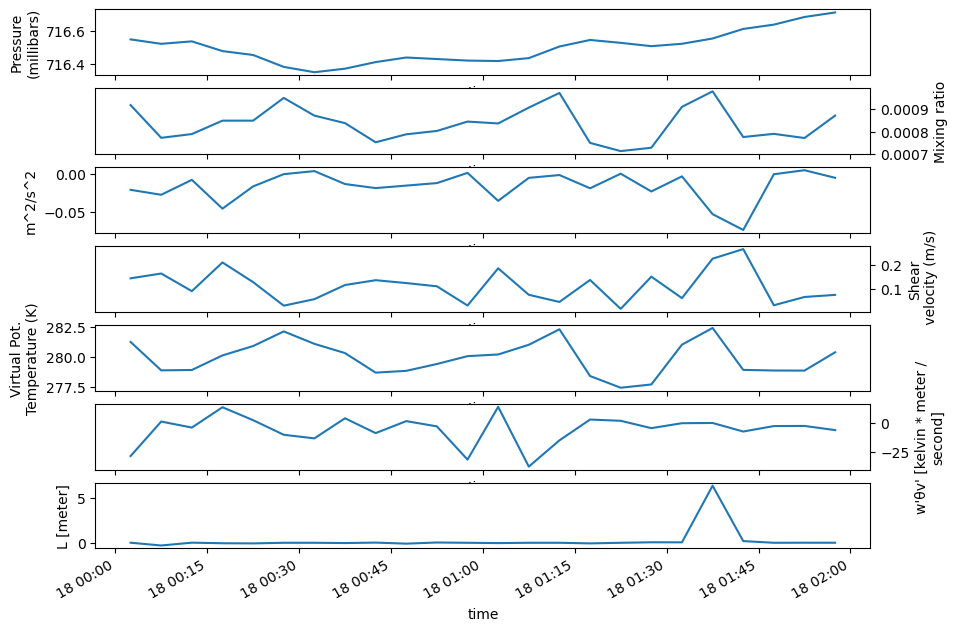

In [175]:

fig, axes = plt.subplots(7,1, figsize=(10,7), sharex=True)

pressure.name = 'Pressure'
pressure.plot(ax=axes[0])
axes[0].set_ylabel("Pressure\n(millibars)")

mixing_ratio.name = 'Mixing ratio'
mixing_ratio.plot(ax=axes[1])
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_ylabel("Mixing ratio")

vertical_turb_momentum_flux.name = "u'w'"
vertical_turb_momentum_flux.plot(ax=axes[2])
axes[2].set_ylabel("m^2/s^2")

shear_velocity.name = 'Shear velocity'
shear_velocity.plot(ax=axes[3])
axes[3].yaxis.set_label_position("right")
axes[3].yaxis.tick_right()
axes[3].set_ylabel("Shear\n velocity (m/s)")


virtual_potential_temperature.name = 'Virtual Pot. Temp'
virtual_potential_temperature.plot(ax=axes[4])
axes[4].set_ylabel("Virtual Pot.\nTemperature (K)")

vertical_velocity_virtual_potential_temperature_covariance.name = r"w'θv'"
vertical_velocity_virtual_potential_temperature_covariance.plot(ax=axes[5])
axes[5].yaxis.set_label_position("right")
axes[5].yaxis.tick_right()
axes[5].set_label("w'θv'\n(K m/s)")


obukhov_length.name = 'L'
obukhov_length.plot(ax=axes[6])
# axes[6].set_ylim(-.2,.2)
axes[6].set_label("L (m)")

# for ax in axes:
#     ax.yaxis.label.set_fontsize(8)

# Apply M.O.S.T. Models

Holtslag and de Bruin (1988) 

$$ \Phi_m (z/L) = 1 + 0.7(z/L) + 0.75(z/L)(6 - 0.35(z/L))exp(-0.35(z/L))$$

$$ \frac{d\overline{u}}{dz} = \frac{u_*}{k z} \Phi_m(z/L) $$

$$ \overline{u} = \int \frac{u_*}{k z} \Phi (z/L) dz $$

Using wolfram to integrate the above (treating $u_*$ and  $k$ as constants),

$$ \overline{u} = (u_*/k)(1/L)(e^{-0.35 z/L}(0.75 z - 10.7143L)) + (1/L)0.7z + log(z)$$ 

In [176]:
def profile_function(z, L, shear_velocity):
    k = 0.4
    return (shear_velocity/k)*(1/L)*(np.exp(-0.35*z/L)*(0.75*z - 10.7143*L)) + (1/L)*0.7*z + np.log(z)

In [177]:
mean_obukhov_length = obukhov_length.mean().values.item()
mean_shear_velocity = shear_velocity.mean().values.item()

mean_obukhov_length, mean_shear_velocity

(0.25380662083625793, 0.11189291626214981)

In [140]:
profile_comparison_df = tidy_streamwise_indexed_df.groupby(['tower', 'height', 'measurement']).mean().loc['c', :, 'u'].reset_index()

/tmp/ipykernel_27813/2955715082.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profile_comparison_df = tidy_streamwise_indexed_df.groupby(['tower', 'height', 'measurement']).mean().loc['c', :, 'u'].reset_index()


In [163]:
profile_comparison_df['value_model'] = profile_comparison_df['height'].apply(lambda height: profile_function(height, mean_obukhov_length, mean_shear_velocity))

In [164]:
profile_comparison_df

,height,value,value_model
0,1,1.779131,0.953180
1,2,1.919327,4.339371
2,3,1.917548,6.924947
3,5,1.861004,11.440237
4,10,1.535612,21.965192
5,15,1.303388,32.201701
6,20,1.013116,42.320597


<AxesSubplot: xlabel='value_model'>

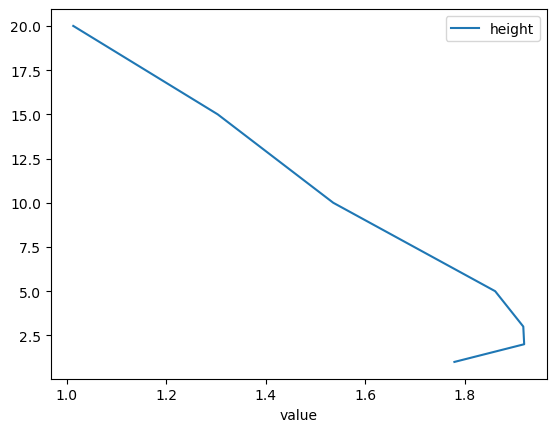

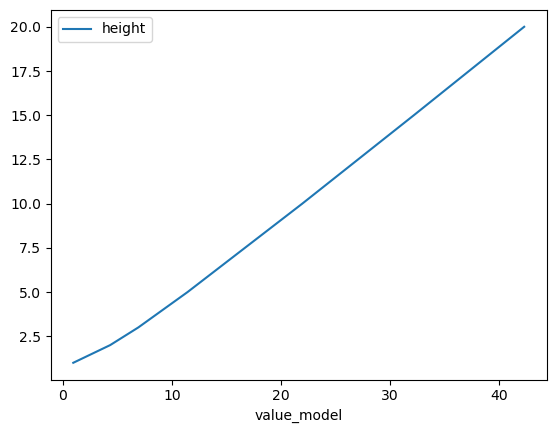

In [165]:
profile_comparison_df.plot('value', 'height')
profile_comparison_df.plot('value_model', 'height')